In [2]:
%matplotlib notebook

In [3]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import celerite
from celerite import terms
import emcee
import corner
from scipy import signal

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


<IPython.core.display.Javascript object>


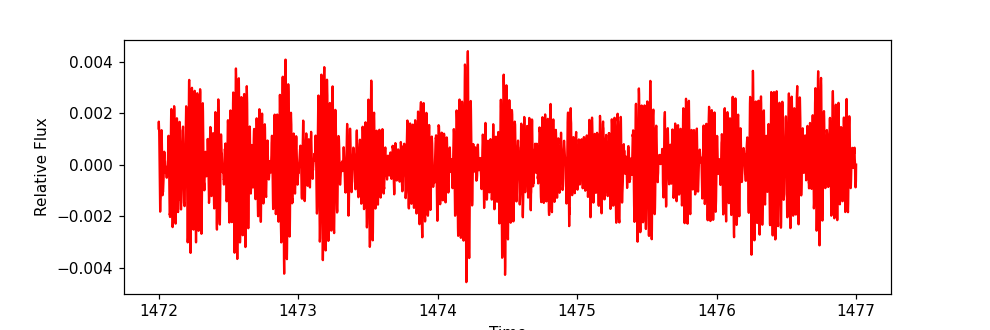

In [6]:
### TESS data import ###
data = np.loadtxt("TESS_data_all.dat",usecols=(0,1))
time = data[:,0]
index = np.argwhere((time>1472)&(time<1477))
time = np.ndarray.flatten(time[index])
# à prendre vers 1472
flux = data[:,1]
flux = np.ndarray.flatten(flux[index])


fig = plt.figure(figsize=(9,3))
ax = plt.gca()
#ax.scatter(time,flux,c="r",s=1)
ax.plot(time,flux,c="r")
ax.set_xlabel("Time")
ax.set_ylabel("Relative Flux")
fig.show()

In [7]:
freqs,amps,phases = np.loadtxt("TESS_freqs.txt",usecols=(1,2,3)).T
freqs_errors,amps_errors,phases_errors = np.loadtxt("TESS_freqs_errors.txt",usecols=(0,1,2)).T

In [8]:
# y = []
# y_error = []
# for i in time:
#     tmp = [] #saves one sine
#     tmp_error = []
#     for freq, amp, phase,freq_error,amp_error,phase_error in zip(freqs, amps, phases,freqs_errors, amps_errors, phases_errors):
# #    for freq_error,amp_error,phase_error in zip(freqs_errors, amps_errors, phases_errors):
#         tmp.append(amp * np.sin(2 * np.pi * freq * i + phase * 2 * np.pi))
#         tmp_error.append((amp+amp_error) * np.sin(2 * np.pi * (freq+freq_error) * i + (phase+phase_error) * 2 * np.pi))
#     y.append(np.sum(tmp))
#     y_error.append(np.sum(tmp_error))
# y = np.array(y)
# flux_error = np.array(y_error)

# y = (y - np.mean(y))/(np.max(y) - np.mean(y))
# flux_error = (flux_error - np.mean(flux_error))/(np.max(flux_error) - np.mean(flux_error))
# flux_error = y - flux_error

In [9]:
# plt.figure(figsize=(9,3))
# plt.plot(time,flux-flux_error)
# plt.show()

In [10]:
### GP Model ###
bounds = dict(log_S0= (None,None), log_Q = (-10,10), log_omega0 = (5,7))
#kernel = terms.SHOTerm(log_S0=7., log_Q=2.5, log_omega0=5.)
kernel = terms.SHOTerm(log_S0=1., log_Q=2.5, log_omega0=5.80,bounds=bounds)


gp = celerite.GP(kernel,mean=0.0)
gp.compute(time,yerr=2*1e-7)


print("Initial log likelihood: {0}".format(gp.log_likelihood(flux)))
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))

Initial log likelihood: -11557.877789364338
parameter_dict:
OrderedDict([('kernel:log_S0', 1.0), ('kernel:log_Q', 2.5), ('kernel:log_omega0', 5.8)])



In [11]:
x = np.linspace(np.min(time),np.max(time),15000)
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

<IPython.core.display.Javascript object>


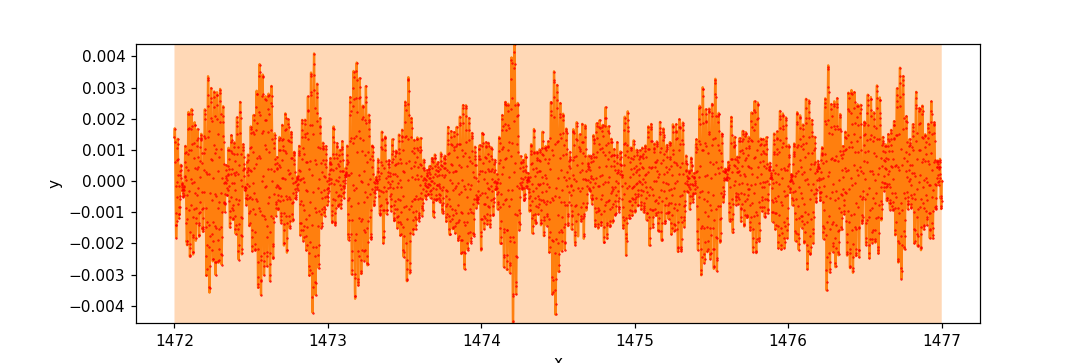

In [12]:
color = "#ff7f0e"
#plt.scatter(time,flux,c="r",s=1)
plt.figure(figsize=(9,3))
plt.errorbar(time,flux,yerr=0,fmt=".r",capsize=0,markersize=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(flux),np.max(flux))
plt.show()

In [13]:
### Minimize ###
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)
# extract our initial guess at parameters
# from the celerite kernel and put it in a 
# vector:
p0 = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

# run optimization:
results = minimize(neg_log_like, p0, method='L-BFGS-B',bounds=bounds,args=(flux, gp))
print(results)
print("Final log-likelihood: {0}".format(-results.fun))
print(np.exp(results.x))
print("Parameters: {0}".format(gp.get_parameter_dict()))
gp.set_parameter_vector(results.x)

      fun: -24316.095856050662
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.2016244 ,  5.01531758, -3.79732228])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 132
      nit: 15
   status: 0
  success: True
        x: array([-19.84716084,   0.88197468,   5.80025519])
Final log-likelihood: 24316.095856050662
[2.40152751e-09 2.41566517e+00 3.30383860e+02]
Parameters: OrderedDict([('kernel:log_S0', -19.84716084151662), ('kernel:log_Q', 0.8819746831199872), ('kernel:log_omega0', 5.800255200261914)])


In [14]:
### Prédiction avec les nouveaux paramètres calculés ###
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

<IPython.core.display.Javascript object>


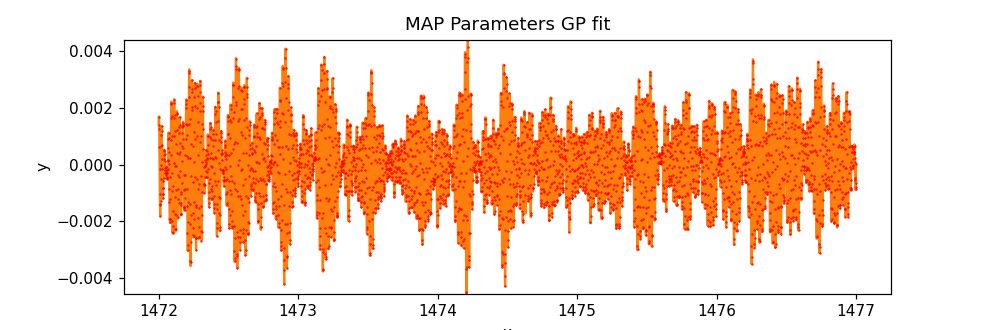

In [15]:
### Plot du posterior du minimize ###
color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.errorbar(time,flux,yerr=0,fmt=".r",capsize=0,markersize=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(flux),np.max(flux))
plt.title("MAP Parameters GP fit")
plt.show()
# plt.scatter(x,flux - pred_mean,c='k',s=1)
# plt.axhline(y=0,color='k')
# plt.title("Residuals")
# plt.show()

In [16]:
### Définition de la likelihood ###
def log_likelihood(params,time,flux):
    gp.set_parameter_vector(params)
    ll = gp.log_likelihood(flux)
    return ll if np.isfinite(ll) else -np.inf

In [17]:
### Définition du prior (uniforme) ###
def log_prior(params):
    if ((-20 < params[0] < 10) and (-10 < params[1] < 10) and (5 < params[2] < 7)) :
        return 0
    return -np.inf

In [18]:
### Définition du posterior ###
def log_probability(params,time,flux):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,time,flux) if np.isfinite(lp) else -np.inf

In [19]:
### MCMC ###
initial = np.array(results.x)
ndim, nwalkers = len(initial), 128
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,args=(time,flux))

print("Running burn-in...")
p0 = initial + 1e-4 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500,progress=True)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 5000,progress=True)
print("Finished")

  0%|          | 0/500 [00:00<?, ?it/s]

Running burn-in...


100%|██████████| 500/500 [01:06<00:00,  7.56it/s]


Running production...


100%|██████████| 5000/5000 [11:42<00:00,  7.12it/s]

Finished


In [20]:
print("Final MCMC Parameters: {0}".format(gp.get_parameter_dict()))
print("Final MCMC log likelihood: {0}".format(gp.log_likelihood(flux)))

Final MCMC Parameters: OrderedDict([('kernel:log_S0', -19.946954051665287), ('kernel:log_Q', 0.9506069238023089), ('kernel:log_omega0', 5.822590038660492)])
Final MCMC log likelihood: 24313.72645722253


In [21]:
w = np.exp(gp.get_parameter_vector())
print(w)
f = w[2]/(2*np.pi)
f

[2.17344135e-09 2.58727946e+00 3.37845956e+02]


53.76985382266611

In [22]:
P = 1/f
print("periode :",P*24*60,"min")

periode : 26.780805556011824 min


In [23]:
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

<IPython.core.display.Javascript object>


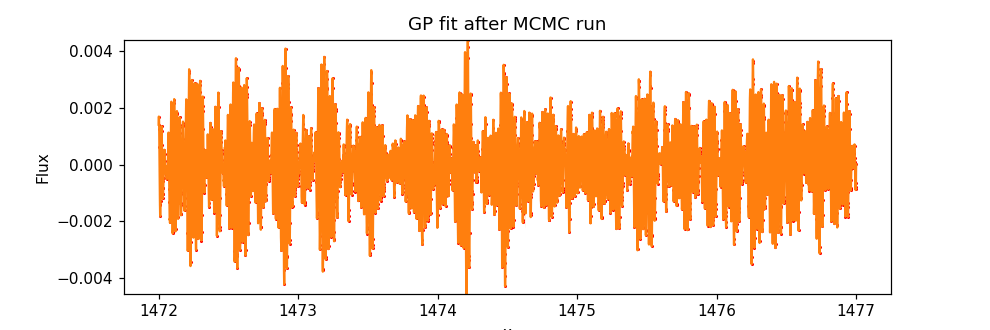

In [24]:
# Plot the data.

# Plot 24 posterior samples.
color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.scatter(time,flux,c="r",s=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("Flux")
plt.ylim(np.min(flux),np.max(flux))
plt.title("GP fit after MCMC run")
plt.show()

<IPython.core.display.Javascript object>


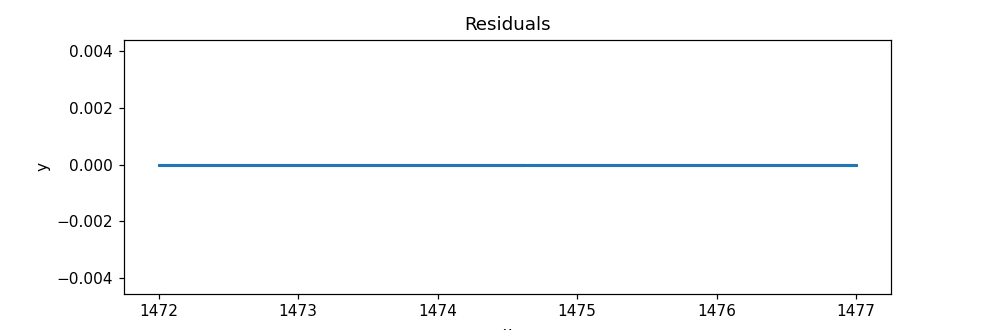

In [25]:
### Résidus ###
pred_mean, pred_var = gp.predict(flux, time, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.scatter(time,flux - pred_mean,s=1)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(flux),np.max(flux))
plt.title("Residuals")
plt.show()

<IPython.core.display.Javascript object>


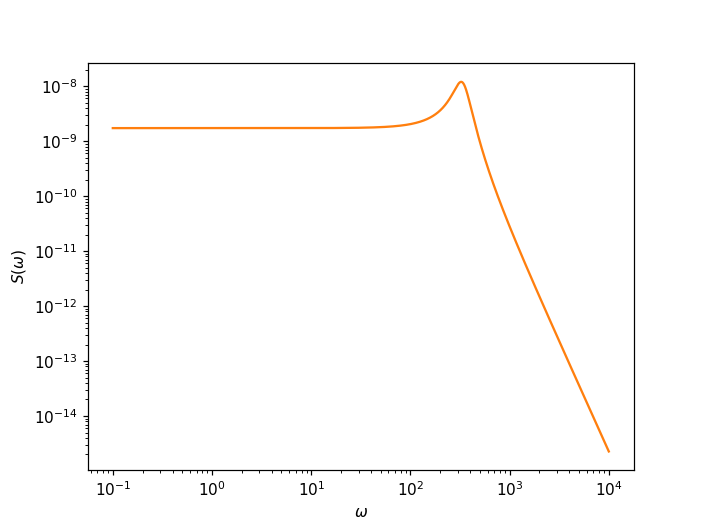

In [26]:
### PSD en fonction de omega ###
plt.figure()
omega = np.exp(np.linspace(np.log(0.1), np.log(10000), 5000))
psd = gp.kernel.get_psd(omega)
plt.plot(omega, psd, color=color)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$")
plt.show()

(41728, 3)


<IPython.core.display.Javascript object>


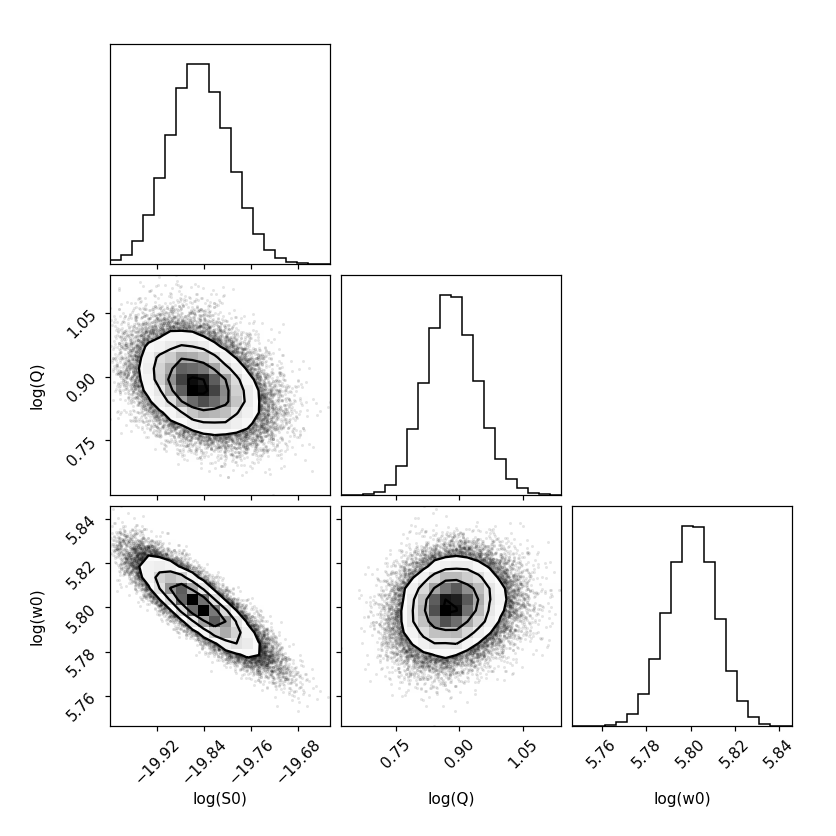

In [27]:
### Posteriors ###
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)
labels = ["log(S0)","log(Q)","log(w0)"]
fig = corner.corner(flat_samples, labels=labels, truths=[None,None,np.log(2*np.pi*24*60/30.4)])
plt.show()

In [28]:
tau = sampler.get_autocorr_time()
print(tau)

[36.4685108  36.68699026 35.7875181 ]


<IPython.core.display.Javascript object>


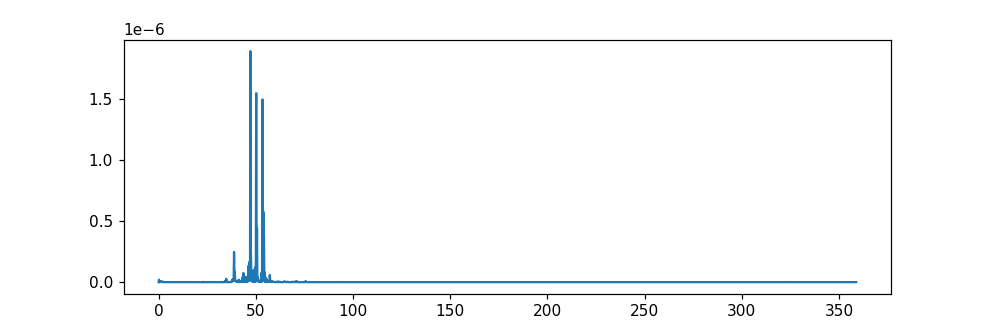

freq: 47.2002605228498 d-1
periode 30.508306184091747 min


In [29]:
### Périodogramme des résidus ###
fs = len(time)/(time[-1] - time[0])
f,pxx = signal.periodogram(pred_mean,fs)
plt.figure(figsize=(9,3))
plt.plot(f,pxx)
plt.show()
idx = np.argmax(pxx)
print("freq:", f[idx],"d-1")
print("periode",1/f[idx]*60*24,"min")

In [30]:
### Data comet ###
comet_time = data[:,0]
index = np.argwhere((comet_time>1485)&(comet_time<1489))
comet_time = np.ndarray.flatten(comet_time[index])
# à prendre vers 1472
comet_flux = data[:,1]*1000
comet_flux = np.ndarray.flatten(comet_flux[index])

<IPython.core.display.Javascript object>


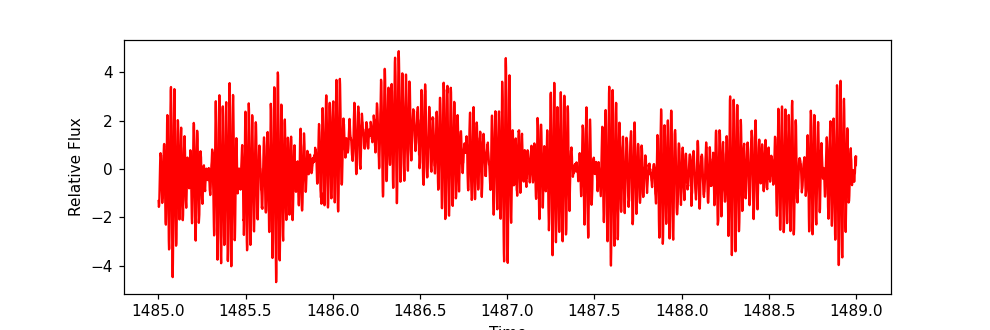

In [31]:
fig = plt.figure(figsize=(9,3))
ax = plt.gca()
#ax.scatter(time,flux,c="r",s=1)
ax.plot(comet_time,comet_flux,c="r")
ax.set_xlabel("Time")
ax.set_ylabel("Relative Flux")
fig.show()

In [32]:
x = np.linspace(np.min(comet_time),np.max(comet_time),15000)
gp.compute(comet_time,yerr=0)
pred_mean, pred_var = gp.predict(comet_flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

C:\ProgramData\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)


<IPython.core.display.Javascript object>


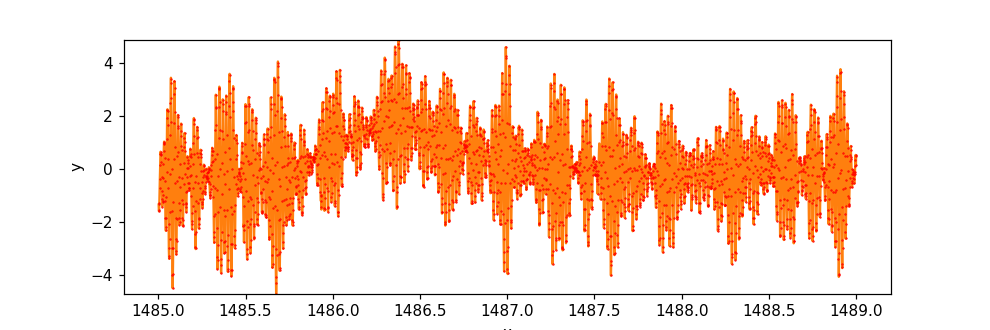

In [33]:
color = "#ff7f0e"
#plt.scatter(time,flux,c="r",s=1)
plt.figure(figsize=(9,3))
plt.errorbar(comet_time,comet_flux,yerr=0,fmt=".r",capsize=0,markersize=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(comet_flux),np.max(comet_flux))
plt.show()

In [104]:
rv_data = np.loadtxt("rv_betapic_carine.txt",usecols=(0,1,2))
rv_time = rv_data[:,0]
rv_flux = rv_data[:,1]
rv_error = rv_data[:,2]
index = np.argwhere(rv_time>=3333)
rv_flux = np.ndarray.flatten(rv_flux[index])
rv_time = np.ndarray.flatten(rv_time[index])
rv_error = np.ndarray.flatten(rv_error[index])

<IPython.core.display.Javascript object>


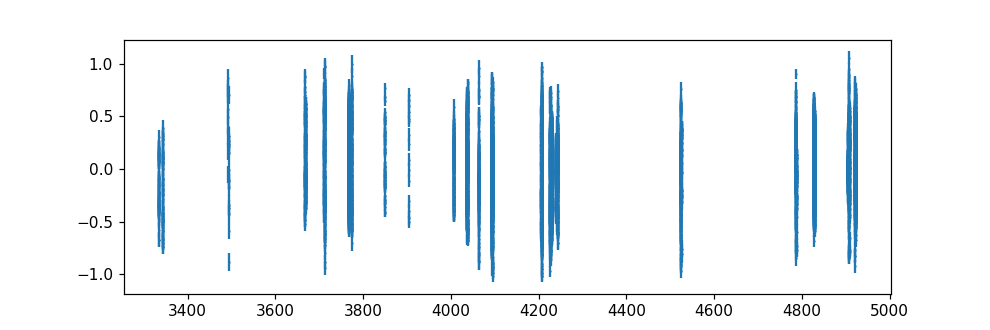

In [105]:
plt.figure(figsize=(9,3))
plt.errorbar(rv_time,rv_flux,yerr=rv_error,markersize=1,capsize=0,fmt='.')
plt.show()

<IPython.core.display.Javascript object>


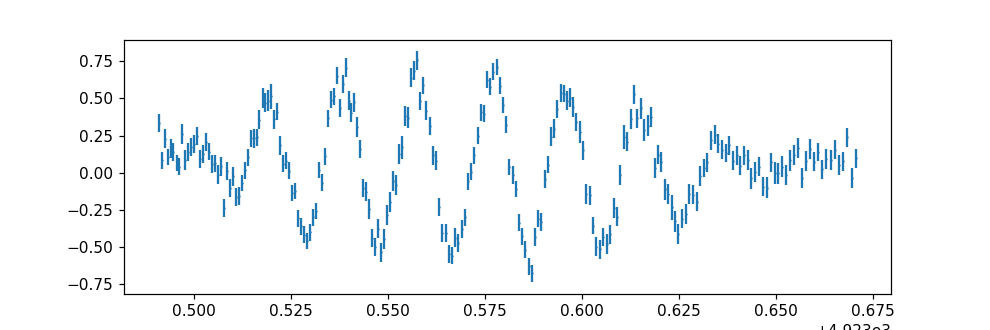

In [106]:
### Data à traiter ###
index = np.argwhere((rv_time>4923)&(rv_time<4924))
rv_flux = np.ndarray.flatten(rv_flux[index])
rv_time = np.ndarray.flatten(rv_time[index])
rv_error = np.ndarray.flatten(rv_error[index])
plt.figure(figsize=(9,3))
plt.errorbar(rv_time,rv_flux,yerr=rv_error,markersize=1,capsize=0,fmt='.')
plt.show()

In [107]:
### Récupération des hyperparamètres ###
p_old = gp.get_parameter_vector()

In [108]:
p = p_old
### GP Model ###
bounds = dict(log_S0= (None,None), log_Q = (-10,10), log_omega0 = (5,7))
#kernel = terms.SHOTerm(log_S0=7., log_Q=2.5, log_omega0=5.)
kernel = terms.SHOTerm(log_S0=p[0], log_Q=p[1], log_omega0=p[2],bounds=bounds)


gp = celerite.GP(kernel,fit_mean=True)
gp.compute(rv_time,yerr=rv_error)


print("Initial log likelihood: {0}".format(gp.log_likelihood(rv_flux)))
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))

Initial log likelihood: 126.93691026683092
parameter_dict:
OrderedDict([('kernel:log_S0', -11.756738657019346), ('kernel:log_Q', 4.13151054134912), ('kernel:log_omega0', 5.6288207608657785), ('mean:value', 0.0)])



In [109]:
### Définition de la likelihood ###
def log_likelihood(params,time,flux):
    gp.set_parameter_vector(params)
    ll = gp.log_likelihood(flux)
    return ll if np.isfinite(ll) else -np.inf

In [110]:
### Définition du prior (uniforme) ###
def log_prior(params):
    if ((-20 < params[0] < 10) and (-10 < params[1] < 10) and (5 < params[2] < 7) and (-10 < params[3] < 10)) :
        return 0
    return -np.inf

In [111]:
### Définition du posterior ###
def log_probability(params,time,flux):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,time,flux) if np.isfinite(lp) else -np.inf

In [112]:
### MCMC ###
initial = gp.get_parameter_vector()
ndim, nwalkers = len(initial), 128
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,args=(rv_time,rv_flux))

print("Running burn-in...")
p0 = initial + 1e-4 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500,progress=True)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 5000,progress=True)
print("Finished")

  0%|          | 0/500 [00:00<?, ?it/s]

Running burn-in...


  0%|          | 0/5000 [00:00<?, ?it/s]

Running production...


100%|██████████| 5000/5000 [02:03<00:00, 40.64it/s]

Finished


In [113]:
print("Final MCMC Parameters: {0}".format(gp.get_parameter_dict()))
print("Final MCMC log likelihood: {0}".format(gp.log_likelihood(rv_flux)))

Final MCMC Parameters: OrderedDict([('kernel:log_S0', -11.3834596607185), ('kernel:log_Q', 4.441443998563461), ('kernel:log_omega0', 5.737786975806447), ('mean:value', 0.06463932898005616)])
Final MCMC log likelihood: 208.44156257298977


In [114]:
w = np.exp(gp.get_parameter_vector())
print(w)
f = w[2]/(2*np.pi)
f

[1.13822019e-05 8.48974450e+01 3.10376779e+02 1.06677420e+00]


49.39799860958254

In [115]:
P = 1/f
print("periode :",P*24*60,"min")

periode : 29.1509785928991 min


In [116]:
x = np.linspace(np.min(rv_time),np.max(rv_time),15000)
pred_mean, pred_var = gp.predict(rv_flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

<IPython.core.display.Javascript object>


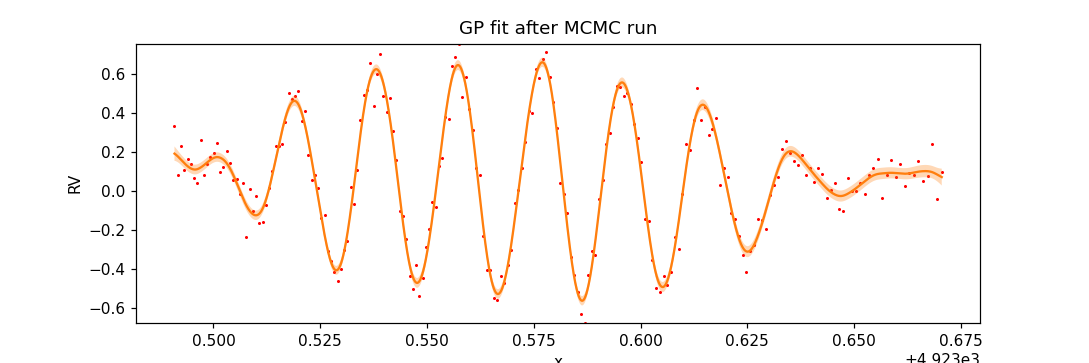

In [117]:
# Plot the data.

# Plot 24 posterior samples.
color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.scatter(rv_time,rv_flux,c="r",s=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("RV")
plt.ylim(np.min(rv_flux),np.max(rv_flux))
plt.title("GP fit after MCMC run")
plt.show()

<IPython.core.display.Javascript object>


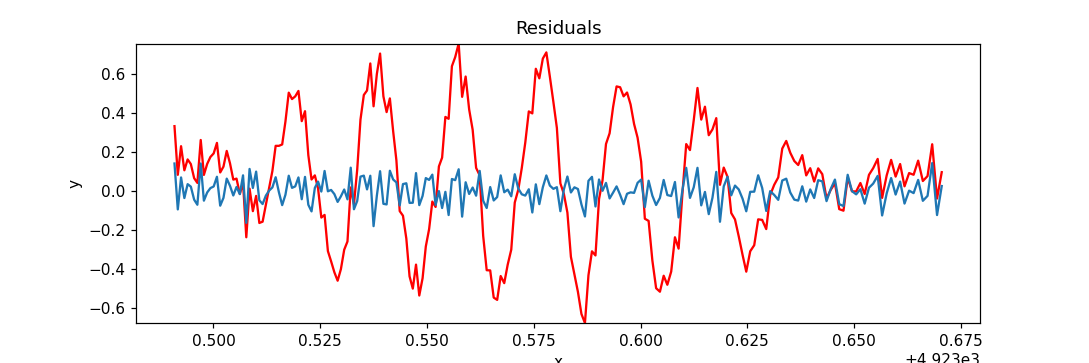

In [118]:
### Résidus ###
pred_mean, pred_var = gp.predict(rv_flux, rv_time, return_var=True)
pred_std = np.sqrt(pred_var)
res = rv_flux - pred_mean
color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.plot(rv_time,rv_flux,c="r")
plt.scatter(rv_time,res,s=1)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(rv_flux),np.max(rv_flux))
plt.title("Residuals")
plt.show()

(41728, 4)


<IPython.core.display.Javascript object>


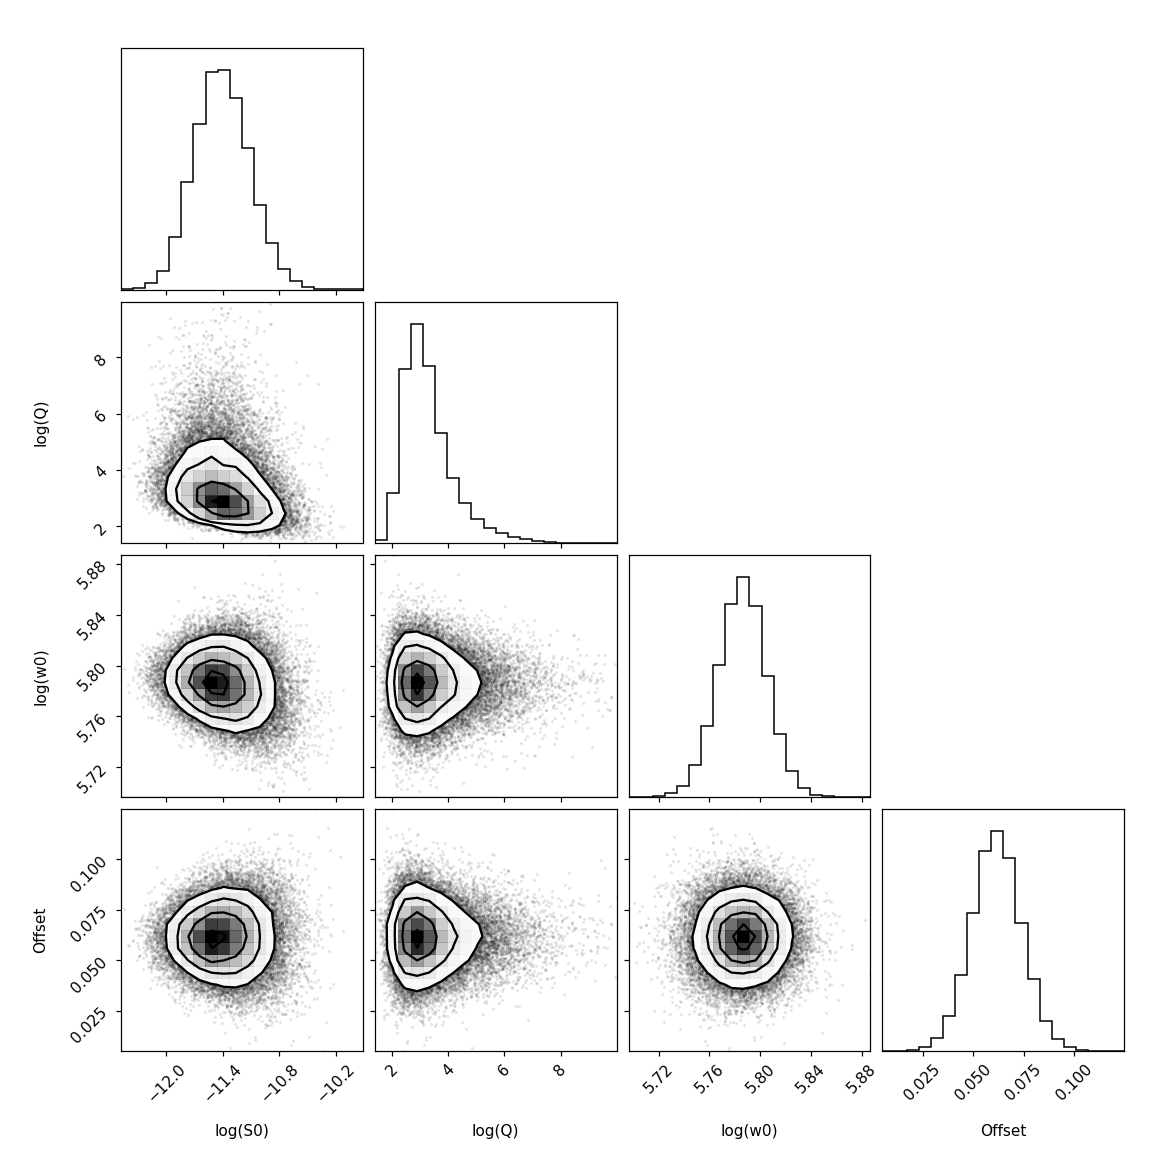

In [119]:
### Posteriors ###
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)
labels = ["log(S0)","log(Q)","log(w0)","Offset"]
fig = corner.corner(flat_samples, labels=labels, truths=[None,None,np.log(2*np.pi*24*60/30.4),None])
plt.show()

In [101]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>